# Simple BB strategy

In [1]:
from binance.client import Client
from downloader import Downloader
import matplotlib.pyplot as plt
dl = Downloader()
import pandas as pd
import time
from datetime import datetime
import numpy as np
import statsmodels.formula.api as sm
import math
import metalabeller as ml

In [2]:
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm

In [3]:
df = dl.get_working_data("ATOMUSDT")

## Hedge ratio calc

In [4]:
df1 = dl.get_working_data("BTCUSDT")
df2 = df

In [5]:
df_ = df1.open.rename("A").to_frame()
df_["B"] = df2.open
df_ = df_[1000:]
df_ = df_.dropna()

In [6]:
start = time.time()
ds = 6000 #downsample
hedge_ratio = np.full(df_.shape[0], np.nan)
l = math.floor(len(hedge_ratio)/ds)
index = []
for t in np.arange(l):
#     clear_output()
#     print(f"{t} < {l}")
    regress_results = sm.ols(formula="B ~ A",
                             data=df_[:t*ds+1]).fit()  # Note this can deal with NaN in top row
    hedge_ratio[t] = regress_results.params[1]
    index.append(df_.index[t*ds+1])
time.time()-start

33.233266830444336

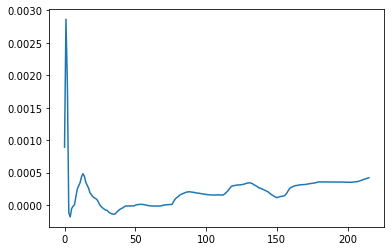

In [7]:
plt.plot(hedge_ratio)

In [8]:
def get_spread(hedge_ratio, index, df, lookback):
    """returns the spread. Lookback is for mean and std. length is [-length:] of spread"""
    hr = pd.Series(hedge_ratio).dropna().rename("hr").to_frame()

    hr["index"] = index
    hr.set_index("index", inplace=True)

    spread = pd.DataFrame(hr.hr, index=df.index)

    spread.ffill(inplace=True)

    spread = pd.Series((df['B'] - spread["hr"] * df['A'])).rename("spread").to_frame()
    spread["mean"] = spread.spread.rolling(lookback).mean()
    spread["std"] =  spread.spread.rolling(lookback).std()
    spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])

    spread = spread.dropna()
    return spread

In [9]:
spread = get_spread(hedge_ratio, index, df_, 60*24*30)

In [10]:
spread

,spread,mean,std,zscore
timestamp,,,,
2019-05-29 14:00:00,4.627278,0.244795,6.455399,0.678886
2019-05-29 14:01:00,4.628218,0.244913,6.455432,0.679010
2019-05-29 14:02:00,4.633209,0.245031,6.455466,0.679762
2019-05-29 14:03:00,4.652212,0.245153,6.455500,0.682683
2019-05-29 14:04:00,4.660150,0.245273,6.455533,0.683890
...,...,...,...,...
2021-10-20 23:08:00,8.279111,14.817421,5.819513,-1.123515
2021-10-20 23:09:00,8.252404,14.817188,5.819575,-1.128052
2021-10-20 23:10:00,8.213300,14.816956,5.819638,-1.134719


In [90]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate, std=2):
    sma = get_sma(prices, rate) # <-- Get SMA for 20 days
    std_ = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std_ * std # Calculate top band
    bollinger_down = sma - std_ * std # Calculate bottom band
    return bollinger_up, bollinger_down

def get_bb_side(df, cooldown=7*24*60):
    ind_ = df.index
    ind = []
    side_ = []
    bought=False
    c = cooldown
    df_ = df.to_numpy()
    diff = df.bb_h.diff()/df.open
    for i in range(len(df_)):
#         if (df_[i][1]>df_[i][5]) and (diff.iloc[i]>0.0003):
        if (df_[i][1]>df_[i][5]) and spread.iloc[i].zscore<-1:
            if not bought:
                bought=True
                ind.append(i)
                side_.append(1)
            c=cooldown
#             else:
#                 c -= 1
#                 if c==0:
#                     c=cooldown
#                     bought=False
#         elif (df_[i][2]<df_[i][6]) and diff.iloc[i]<-0.0003:
#             if not bought:
#                 bought=True
#                 ind.append(i)
#                 side_.append(-1)
# #             else:
# #                 c -= 1
# #                 if c==0:
# #                     c=cooldown
# #                     bought=False
        else:
            c-=1 if (c!=0) else 0
            if (c==0): bought=False
    ind = list(map(lambda x: ind_[x], ind))
    return pd.Series(side_, index=ind)

def get_bb_side1(df, cooldown=7*24*60):
    ind_ = df.index
    ind = []
    side_ = []
    bought=False
    c = cooldown
    df_ = df.to_numpy()
    diff = df.bb_h.diff()/df.open
    for i in range(len(df_)):
#         if (df_[i][1]>df_[i][5]) and (diff.iloc[i]>0.0003):
        if (df_[i][1]>df_[i][5]) and spread.iloc[i].zscore<-1:
            if not bought:
                bought=True
                ind.append(i)
                side_.append(1)
            c=cooldown
        elif (df_[i][2]<df_[i][6]) and spread.iloc[i].zscore>1:
            if not bought:
                bought=True
                ind.append(i)
                side_.append(-1)
            c=cooldown
        else:
            c-=1 if (c!=0) else 0
            if (c==0): bought=False
    ind = list(map(lambda x: ind_[x], ind))
    return pd.Series(side_, index=ind)

In [92]:
df["bb_h"], df["bb_l"] = get_bollinger_bands(df.open, 21*60)
df.dropna(inplace=True)
df = df.reindex(spread.index)
side = get_bb_side1(df, cooldown=7*24*60)

In [41]:
vol = ml.get_daily_vol(df.open, span=7*24*60, days=7, hours=0)
t_events = ml.get_t_events(df.open, vol, 0.02, pos=False)

In [73]:
len(t_events)

971

In [74]:
spread["mvg"] = get_sma(df.open, 60*24*14)

In [63]:
side = []
z_lim = 1 #min z score
z_avg = 0 #min average zscore
z_t = pd.Timedelta(days=14) #average over how long
t_events = list(filter(lambda x: x-z_t>=spread.index[0] and x<=spread.index[-1], t_events))
for date in t_events:
    if (spread.loc[date].zscore > z_lim) and \
        (spread.loc[date-z_t:date].zscore.mean() > z_avg):
        side.append(date)
side = pd.Series(1, index=side)

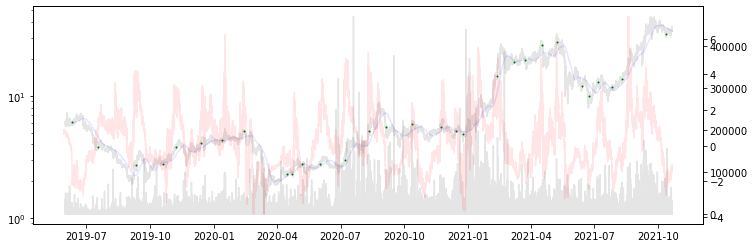

In [93]:
fig, ax=plt.subplots(figsize=(12,4))
ax.set_yscale('log')
ax.plot(df.open, c="black", alpha=0.1)
ax.scatter(side.index, df.reindex(side.index).open, c="green", s=1)
ax.plot(spread.mvg, c="blue", alpha=0.1)
ax1 = ax.twinx()
ax1.plot(df.volume, c="gray", alpha=0.2)
ax2 = ax.twinx()
ax2.plot(spread.zscore, c="red", alpha=0.1)

In [94]:
t1 = ml.get_vertical_barrier(df.open, side.index, num_days=7, hours=0)

verify that get_vertical_barrier works as expected, use above code
remove above remove duplicates code with BTC data and see if it works


In [95]:
t1

2019-06-10 23:34:00   2019-06-17 23:34:00
2019-07-18 12:20:00   2019-07-25 12:20:00
2019-09-10 13:18:00   2019-09-17 13:18:00
2019-10-19 12:57:00   2019-10-26 12:57:00
2019-11-07 01:44:00   2019-11-14 01:44:00
2019-12-13 13:59:00   2019-12-20 13:59:00
2020-01-11 21:45:00   2020-01-18 21:45:00
2020-02-12 23:40:00   2020-02-19 23:40:00
2020-04-14 12:49:00   2020-04-21 12:49:00
2020-04-22 05:52:00   2020-04-29 05:52:00
2020-05-06 04:31:00   2020-05-13 04:31:00
2020-05-31 22:44:00   2020-06-07 22:44:00
2020-07-06 21:55:00   2020-07-13 21:55:00
2020-08-11 08:39:00   2020-08-18 08:39:00
2020-09-04 21:57:00   2020-09-11 21:57:00
2020-10-12 10:42:00   2020-10-19 10:42:00
2020-11-22 10:55:00   2020-11-29 10:55:00
2020-12-13 22:19:00   2020-12-20 22:19:00
2020-12-24 13:55:00   2020-12-31 13:55:00
2021-02-10 12:33:00   2021-02-17 12:33:00
2021-03-07 06:59:00   2021-03-14 06:59:00
2021-03-23 16:35:00   2021-03-30 16:35:00
2021-04-16 01:48:00   2021-04-23 01:48:00
2021-05-08 15:55:00   2021-05-15 1

In [96]:
ptsl = [1,1]
min_ret = 0.00
    
events = ml.get_events(df.open,side.index,ptsl,vol,min_ret,1,t1=t1,side=side)
labels = ml.get_bins(events, df.open, t1)

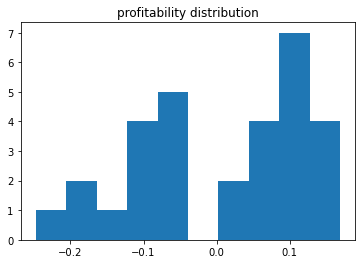

In [97]:
labels = labels[labels.ret != 0]
fig, ax = plt.subplots()
ax.set_title('profitability distribution')
ax.hist(labels.ret)
plt.show()

In [98]:
labels.mean()

ret       0.006696
target    0.566667
dtype: float64

<AxesSubplot:>

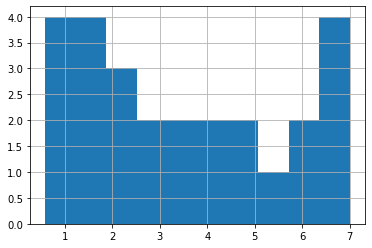

In [89]:
new = pd.to_numeric(events.t1-events.index)/86400000000000
new.hist()

In [52]:
events

,t1,trgt,side
2019-11-08 01:12:00,2019-11-10 15:57:00,0.071286,1
2019-11-08 13:24:00,2019-11-10 11:28:00,0.069472,1
2019-11-09 03:37:00,2019-11-10 14:33:00,0.063938,1
2019-11-10 11:50:00,2019-11-10 17:54:00,0.054370,1
2019-11-11 13:58:00,2019-11-12 15:21:00,0.055101,1
...,...,...,...
2021-09-24 11:11:00,2021-09-24 21:43:00,0.162939,1
2021-09-24 21:39:00,2021-09-26 07:51:00,0.153803,1
2021-09-26 00:51:00,2021-10-03 00:51:00,0.145009,1
2021-09-26 16:30:00,2021-09-28 15:18:00,0.149207,1


In [53]:
labels

,ret,target
2019-11-08 01:12:00,0.072523,1.0
2019-11-08 13:24:00,0.070213,1.0
2019-11-09 03:37:00,0.066393,1.0
2019-11-10 11:50:00,0.055295,1.0
2019-11-11 13:58:00,-0.055452,0.0
...,...,...
2021-09-24 11:11:00,0.165213,1.0
2021-09-24 21:39:00,-0.155156,0.0
2021-09-26 00:51:00,-0.011500,0.0
2021-09-26 16:30:00,-0.150579,0.0
